# Практическое задание 3 

# Классификация с использованием BERT  и Transfer learning

## курс "Математические методы анализа текстов"


### ФИО: Ксенофонтов Григорий

## Введение


В этом задании вы будете определять категории товара по данным из чеков, предоставленным в соревновании [Data Fusion Context](https://boosters.pro/championship/data_fusion/data).


Для этого задания вам понадобятся следующие библиотеки:
 - [Pytorch](https://pytorch.org/).
 - [Transformers](https://github.com/huggingface/transformers).
 - [Tokenizers](https://github.com/huggingface/tokenizers).

Данные лежат в архиве data.zip, в котором лежит файл `data.csv`, содержащий тексты и соответствующие им категории товаров. Все объекты поделены между train, test, val и unsupervised. Для unsupervised объектов категории товаров недоступны. 

Скачать данные можно здесь: [ссылка на google диск](https://drive.google.com/file/d/1AHs7qJYg2tc8zblGlT0Dpe50e6RW-gAW/view?usp=sharing)

In [1]:
import tests

## Часть 1. Подготовка данных (2 балла)

Классические методы NLP (например, как мы делали в первом и втором домашнем задании) преобразуют тексты в списки индексов следующим образом:
1. "Очистка текста" от плохих символов, приводим (или не приводим) текст к нижнему регистру.
2. Текст делится по пробелам на слова.
3. По полученной коллекции текстов строится словарь вида "слово -> индекс", редкие слова выбрасываются, стопслова иногда тоже
4. Побитый на слова текст превращается в список индексов с помощью этого словаря.

Для трансформеров схема выглядит немного по-другому — используются более продвинутые методы токенизации типа `wordpiece, bpe, sentencepiece`. Основное концептуальное отличие — текст делится не только на слова по пробелам, но и сами слова делятся на "подслова" (читай subwords). Это верно для BPE и wordpiece, а sentencepiece вообще не учитывает пробелы. Более подробно ознакомиться с этими методами токенизации можно в наших лекциях.

В данном задании предлагается использовать wordpiece токенизатор, который использовали в оригинальной статье про BERT. Построить его можно с помощью библиотеки `tokenizers`:
1. Считайте данные с помощью `pandas`
2. Используя метод `tokenizers.BertWordPieceTokenizer.train` и список сырых текстов постройте токенизатор. Используйте нижний регистр (lowercase), чистый текст (clean_text), без акцентов (strip_accents), размера словаря 30000 (vocab_size).
3. Сохраните построенный токенизатор (метод `tokenizer.save_model`) и создайте объект класса `transformers.BertTokenizerFast`, который работает быстрее стандартной реализации, но не позволяет её обучать.

**Важно:** нужно при обучении c помощью параметра `special_tokens` завести индексы для токенов `[PAD], [UNK], [CLS], [SEP], [MASK]`, которые понадобятся нам дальше для обучения и использования модели.

In [2]:
import pandas as pd

data = pd.read_csv('data/task3_data.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3155764 entries, 0 to 3155763
Data columns (total 3 columns):
 #   Column  Dtype 
---  ------  ----- 
 0   text    object
 1   label   int64 
 2   split   object
dtypes: int64(1), object(2)
memory usage: 72.2+ MB


In [3]:
from tokenizers import BertWordPieceTokenizer
from transformers import BertTokenizerFast

import os, shutil


class WordpieceTokenizer:

    def __init__(
            self, 
            vocab_path, 
            strip_accents=True, 
            clean_text=True, 
            lowercase=True
    ):
        """
            vocab_path: путь к словарю
            strip_accents: очистка текста от акцентов
            clean_text: просто чистка текста от непонятных символов
            lowercase: приведение текста к нижнему регистру
            
            Подгружает токенизатор с помощью BertTokenizerFast.
        """
        self._tokenizer = BertTokenizerFast(
            ###########################
            ### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
            ###########################
            vocab_file=vocab_path,
            strip_accents=strip_accents,
            do_lower_case=lowercase,
            clean_text=clean_text,
        )

    @classmethod
    def from_corpus(
            cls,
            corpus,
            corpus_save_path,
            tokenizer_save_path,
            tokenizer_name,
            vocab_size=30000,
            min_frequency=2,
            strip_accents=True,
            clean_text=True,
            lowercase=True
    ):
        """
            corpus: список текстов
            corpus_save_path: временный путь для сохранения текстов в текстовом файле
            tokenizer_save_path: путь для сохранения файлов токенизатора
            tokenizer_name: название токенизатора, влияет на названия файлов токенизатора
            vocab_size: размер словаря
            min_frequency: минимальная частота элемента в словаре
            strip_accents: очистка текста от акцентов
            clean_text: просто чистка текста от непонятных символов
            lowercase: приведение текста к нижнему регистру
            
            С помощью списка сырых текстов формирует токенизатор
        """
        ###########################
        ### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
        ###########################
        with open(corpus_save_path, 'w', encoding='utf-8') as file:
            file.write('\n'.join(corpus))

        trainable_tokenizer = BertWordPieceTokenizer(strip_accents=strip_accents,
                                                     clean_text=clean_text,
                                                     lowercase=lowercase)
        trainable_tokenizer.train(files=[corpus_save_path],
                                  vocab_size=vocab_size,
                                  min_frequency=min_frequency,
                                  special_tokens=['[PAD]', '[UNK]', '[CLS]', '[SEP]', '[MASK]'])

        vocab_path = trainable_tokenizer.model.save(tokenizer_save_path, tokenizer_name)[0]
        return cls(
            vocab_path,
            strip_accents,
            clean_text,
            lowercase
        )


    def __call__(self, text):
        """
            text: str. Сырой текст
            
            returns: list of ints. Список индексов
            
            C помощью метода .encode преобразует текст в индексы.
        """
        return self._tokenizer.encode(text, add_special_tokens=False)

    @property
    def cls_token_id(self):
        """
            returns: индекс CLS токена
        """
        return self._tokenizer.cls_token_id

    @property
    def pad_token_id(self):
        return self._tokenizer.pad_token_id

    @property
    def mask_token_id(self):
        return self._tokenizer.mask_token_id

    @property
    def sep_token_id(self):
        return self._tokenizer.sep_token_id

    @property
    def vocab_size(self):
        """
            returns: размер словаря
        """
        return self._tokenizer.vocab_size

Создайте токенизатор:

In [4]:
tokenizer = WordpieceTokenizer.from_corpus(
###########################
### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
###########################
    data['text'],
    'data/corpus_save_path.txt',
    'data',
    'ws_tokenizer'
)
tests.test_tokenizer(tokenizer)

Correct.


Нам доступно довольно большое количество неразмеченных данных, которое можно использовать для предобучения модели. Мы рассмотрим две задачи предобучения:
1. **Masked Language Modeling** — задача из BERT. Выбираем 15% слов, из них 80% заменяем на токен [MASK], 10% меняем на другие случайные слова, 10% оставляем как есть. Эти 15% слов предсказываем моделью. Вспомним пример из оригинальной статьи:
    * Исходный текст: `my dog is hairy`
    * Выбираем случайным образом 15% токенов для задачи. Допустим, выбрали четвертый токен - `hairy`
    * В 80% случаев заменяем токен на `[MASK]`: `my dog is [MASK]`
    * В 10% случаев на другой случайный токен: `my dog is apple`
    * В 10% случаев оставляем неизменным: `my dog is hairy`
    
    
2. **Sentence Order Prediction** — задача из ALBERT. Делим текст на два сегмента, с вероятностью 50% меняет сегменты местами. Предсказываем, в правильном ли порядке находятся сегменты.
    * Текст: `the man went to the store. he bought a gallon of milk`
    * Токенизируем и делим его на два сегмента: `the man went to the store` и `he bought a gallon of milk`
    * C вероятностью 50% меняем их местами: `[CLS] he bought a gallon of milk [SEP] the man went to the store`
    * С вероятностью 50% оставляем на месте: `[CLS] the man went to the store [SEP] he bought a gallon of milk`
    * "Левому" сегменту соответствует нулевой индекс сегмента, "правому" - индекс 1

Большая часть логики предобучения реализуется при подготовке данных.

Реализуйте **PretrainDataset**, который токенизирует поданные сырые тексты и умеет возвращать для текста с конкретным индексом случайный сегмент длины, не большей чем `maxlen`. Логика для задачи **SOP** должна быть реализована в `__getitem__`: выбранный сегмент надо поделить на два равных сегмента, подбросить монетку, и с 50% вероятностью поменять сегменты местами. Нужно также добавить `[CLS]` и `[SEP]` токены.

**hint:** чтобы существенно ускорить обучение (не потеряв при этом в качестве), после токенизации отсортируйте датасет по длине текстов.
**hint:** токенизация датасета для предобучения занимает существенное время (5 минут), поэтому во время отладки стоит сделать её один раз и сохранить результат на диск

In [5]:
import tqdm
import numpy as np
import random

import torch
from torch.utils.data import Dataset


class PretrainDataset(Dataset):
    
    def __init__(
            self, 
            corpus, 
            tokenizer, 
            minlen,
            maxlen,
            permute_prob=0.5, 
            verbose=False, 
            presort=False
    ):
        """
            corpus: list of strings. Список сырых текстов
            tokenizer: токенизатор
            minlen: минимально допустимая длина текста
            permute_prob: вероятность, с которой два сегмента меняются местами (происходит swap)
            maxlen: максимальная длина текста
            verbose: вывод прогресса токенизации текстов с помощью tqdm
            presort: отсортировать датасет по длинам токенизированных текстов (т.е. ds[0] выдает самый короткий текст)
        """
        super().__init__()
        ###########################
        ### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
        ###########################
        if verbose:
            self._corpus = [tokenizer(text) for text in tqdm.tqdm(corpus)]
        else:
            self._corpus = [tokenizer(text) for text in corpus]
        self._corpus = filter(lambda t: len(t) >= minlen, self._corpus)
        if presort:
            self._corpus = sorted(self._corpus, key=lambda x: len(x))

        self._corpus = list(self._corpus)
        self._maxlen = maxlen
        self._tokenizer = tokenizer
        self._permute_prob = permute_prob

    def __len__(self):
        return len(self._corpus)
    
    @property
    def tokenizer(self):
        """
            returns: tokenizer. Нужно для тестов
        """
        return self._tokenizer
    
    def set_maxlen(self, maxlen):
        """
            maxlen: максимальная длина текста
            
            поставить новое максимальное значение длины
        """
        self._maxlen = maxlen
        
    def __getitem__(self, idx):
        """
            returns: 
                input_ids - тензор с индексами, 
                token_type_ids - тензор с сегментными айдишниками (0 у левого сегмента, 1 у правого),
                permuted - был ли swap сегментов
        """
        ###########################
        ### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
        ###########################
        text = self._corpus[idx]
        n = len(text)
        median = n // 2
        if n > self._maxlen:
            start = random.randint(0, n - self._maxlen)
            text = text[start:start + self._maxlen]
            n = len(text)
            median = n // 2
        permuted = random.random() < self._permute_prob
        first = text[:median]
        second = text[median:]
        token_type_ids = torch.cat([torch.zeros(median + 1), torch.ones(n - median + 1)]).long()
        if permuted:
            first, second = second, first
            token_type_ids = torch.cat([torch.ones(median + 1), torch.zeros(n - median + 1)]).long()
        input_ids = torch.LongTensor([self._tokenizer.cls_token_id] + first + [self._tokenizer.sep_token_id] + second)


        return input_ids, token_type_ids, permuted

Длину текстов нужно ограничить снизу. Нет смысла рассматривать слишком короткие тексты (например, единичную длину), для которых задачи предобучения вообще не работают. Длинные тексты более эффективны для задач типа MLM, так как у модели больше контекста для предсказания и больше таргетов на один объект.

Разумный способ определить минимальную длину текстов для MLM  — подобрать такую минимальную длину, чтобы вероятность замаскировать хотя бы одно слово в тексте была больше заданного порога.

Т.е. если мы каждое слово маскируем с вероятностью 15%, какой длины должен быть текст, чтобы с вероятностью $\geqslant$ 50% было замаскировано хотя бы одно слово?

Используйте ответ на данный вопрос как минимальную допустимую длину текстов:

Вероятность того, что в тексте длины $n$ не замаскируется ни одно слово: $(1-p)^n$, где $p=0.15$. Следовательно,
вероятность того, что хотя бы один был замаскирован $1 - (1-p)^n \geq 0.5$. Значит, $n \geq \left \lceil{-\frac{1}{\log_2(1-p)}}\right \rceil $

In [6]:
###########################
### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
###########################
from math import log2, ceil

prob = 0.15
minlen = ceil(-1 / log2(1 - prob))
minlen

5

Создайте датасет (с произвольным разумным значением maxlen):

In [7]:
ds = PretrainDataset(
    ###########################
    ### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
    ###########################
    data['text'],
    tokenizer,
    minlen,
    15,
    verbose=True,
    presort=True
)

100%|██████████| 3155764/3155764 [04:49<00:00, 10884.90it/s]


In [8]:
tests.test_dataset(ds)

Correct.


Длину текстов нужно как-то ограничить сверху. Иначе, если встретится какой-то очень-очень длинный текст, он не поместится в видеопамять. Самый простой способ определить ограничение по длине  — после токенизации построить гистограмму длин (например, используя **sns.distplot**) и методом пристального взгляда определить разумное ограничение длины. Другой вариант  — взять большое значение квантили.

**Вопрос:** какая максимальная длина текста подходит для этого датасета?

array([16., 20., 27.])

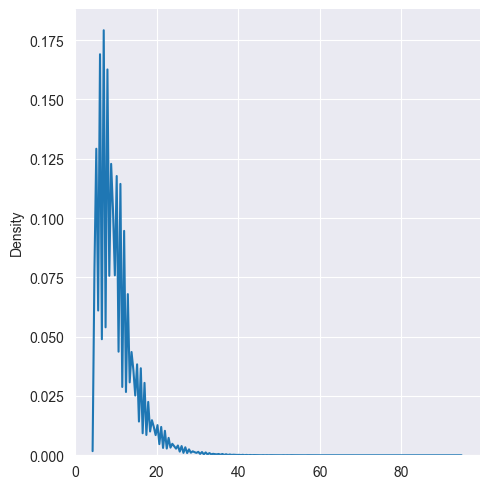

In [9]:
import seaborn as sns


###########################
### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
###########################
lens = list(map(len, ds._corpus))
sns.displot(lens, kind="kde")
np.quantile(lens, [0.9, 0.95, 0.99])

Присвойте максимально допустимое значение длины:

In [10]:
ds.set_maxlen(27)

Если для задачи **SOP** мы готовим данные при индексации датасета `PretrainDataset`, то маскирование для задачи **MLM** удобней делать в Collator'е в тензорном виде.

Как с вероятностью `15%` заменить в тензоре `input_ids` значения на `0`: 

1. `mask = torch.rand(input_ids.shape) < 0.15`
2. `input_ids = torch.where(mask, 0, input_ids)`

Как сгенерировать случайные элементы словаря на каждый элемент батча: `torch.randint_like(input_ids, low=num_special_tokens, high=self._tokenizer.vocab_size)`.

В `Collator` нужно также:
1. сделать паддинг.
2. из (примерно) 15% выбранных токенов 10% поменять на случайные и 10% оставить в исходном виде, остальные замаскировать
3. сформировать таргеты. Нам нужно понимать, какие именно 15% токенов мы выбрали для предсказания + какие были исходные метки для них.

Важно: `[CLS]` и другие специальные токены токены маскировать не надо

In [11]:
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence


class Collator:
    
    def __init__(
            self,
            tokenizer,
            non_target_idx=-100,
            mask_prob=0.15,
            random_prob=0.1,
            keep_unchanged_prob=0.1
    ):
        """
            tokenizer: токенизатор
            non_target_idx: значение для индексов, не использующихся как таргеты. 
                Используйте его, чтобы пометить "не таргет" токены
            mask_prob: вероятность выбрать индекс как таргет
            random_prob: вероятность для уже выбранного индекса поменять его на случайное значение вместо маскирования
            keen_unchanged_prob: вероятность оставить индекс в исходном виде вместо маскирования
        """
        ###########################
        ### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
        ###########################
        self._tokenizer = tokenizer
        self._non_target_idx = non_target_idx
        self._mask_prob = mask_prob
        self._random_prob = random_prob
        self._keep_unchanged_prob = keep_unchanged_prob
        
    def __call__(self, batch):
        """
            batch: список вида [ds[i] for i in [12, 3, 2, 5]]
            
            returns: 
                input_ids: испорченные входные индексы токенов с замаскированными значениями
                token_type_ids: сегментные эмбеддинги
                labels: истинные значения входных индексов, как таргеты
                permuted: был ли свап сегментов
        """
        ###########################
        ### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
        ###########################
        input_ids = []
        token_type_ids = []
        permuted = []
        for inp_ids, tok_ids, perm in batch:
            permuted.append(perm)
            input_ids.append(tok_ids)
            token_type_ids.append(tok_ids)


        input_ids = pad_sequence(input_ids, batch_first=True)
        token_type_ids = pad_sequence(token_type_ids, batch_first=True)
        permuted = torch.LongTensor(permuted)

        mask_not_cls = input_ids != self._tokenizer.cls_token_id
        mask_not_pad = input_ids != self._tokenizer.pad_token_id
        mask_not_sep = input_ids != self._tokenizer.sep_token_id
        mask_chosen = torch.rand(input_ids.shape) < self._mask_prob * mask_not_cls * mask_not_pad * mask_not_sep

        mask_changed = mask_chosen * torch.rand(input_ids.shape) < self._random_prob
        mask_unchanged = (mask_chosen.int() - mask_changed.int()).bool()
        mask_masked = (mask_chosen.int() - mask_changed.int() - mask_unchanged.int()).bool()
        labels = torch.where(mask_masked,
                             input_ids,
                             self._non_target_idx)
        # mask
        input_ids = torch.where(mask_masked, self._tokenizer.mask_token_id, input_ids)
        # change
        input_ids = torch.where(mask_changed,
                                torch.randint_like(input_ids, low=4, high=self._tokenizer.vocab_size),
                                input_ids)
        return input_ids, token_type_ids, labels, permuted

Создайте `collator` и `dataloader`. Для предобучения предлагается использовать большой `batch_size`.

In [12]:
collator = Collator(tokenizer, non_target_idx=-100)

dl = DataLoader(
    ds, 
    collate_fn=collator, 
    batch_size=128,
    shuffle=False
)

In [13]:
tests.test_collator(ds, collator)

Correct.


## Часть 2. Создание модели (2 балла)

В качестве модели мы будем использовать энкодер трансформера точь-в-точь в таком же виде, как его использовали в оригинальной статье про BERT. 

Прежде чем начать писать составляющие энкодера, обсудим инициализацию весов. Для трансформера нам понадобится большое количество линейных слов (`nn.Linear`), у которых для инициализации по дефолту используется равномерное распределение и отсутствует зануление bias'ов: $$\text{Uniform}\left(-\frac{1}{\sqrt{N_{\text{in_features}}}}, \frac{1}{\sqrt{N_{\text{in_features}}}}\right).$$

В оригинальной статье про BERT для весов используется **TruncatedNormal** со стандартным отклонением 0.02, bias'ы инициализируются нулями и модель обучается значительно лучше (это можно в ходе домашнего задания проверить).

Поэтому, после создания линейных слоев и матрицы эмбеддингов, необходимо в явном виде вызывать для них TruncatedNormal инициализацию:

1. `layer = ...`
2. `nn.init.trunc_normal_(layer.weight.data, std=0.02, a=-2 * 0.02, b=2 * 0.02)`.

Для линейных слоев нужно также вызывать `layer.bias.data.zero_()`.


**TruncatedNormal** распределение отличается от нормального тем, что если величины выходят за границы отрезка [a, b], для этих величин повторно происходит сэмплирование до тех пор, пока они не попадут в нужный отрезок. Для BERT stddev = 0.02:

$$[a; b] = [- 2  \cdot \text{stddev}; 2 \cdot \text{stddev}].$$

Напишите функцию для инициализации линейных слоев и матрицы эмбеддингов **TruncatedNormal** распределением:

In [14]:
from torch import nn


def init_layer(layer, initializer_range=0.02, zero_out_bias=True):
    """
        layer: наследник nn.Module, т.е. слой в pytorch
        initializer_range: stddev для truncated normal
        zero_out_bias: True для линейных слоев, False для матрицы эмбеддингов
    """
    ###########################
    ### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
    ###########################
    nn.init.trunc_normal_(layer.weight.data, std=initializer_range, a=-2 * initializer_range, b=2 * initializer_range)
    if zero_out_bias:
        layer.bias.data.zero_()

Приступим к созданию энкодера трансформера.

<img src="images/transformer.png" width=500 height=600 />

Сформируем слой, создающий входные векторы токенов. Для этого нам нужны:
1. Эмбеддинги токенов (`nn.Embedding`)
2. Позиционные эмбеддинги (можно либо использовать `nn.Embedding`, либо явно создать матрицу эмбеддингов с помощью `nn.Parameter`)
3. Сегментные эмбеддинги

Эти три сущности складываются, затем идет layernorm и dropout.

<img src="images/bert_input.png" width=800 height=600 />

In [15]:
class BertEmbeddings(nn.Module):
    
    def __init__(
            self, 
            vocab_size, 
            hidden_size, 
            max_seqlen,
            dropout_prob=0., 
            type_vocab_size=2,
            eps=1e-3
    ):
        """
            vocab_size: размер словаря
            hidden_size: размерность эмбеддингов
            max_seqlen: количество позиционных эмбеддингов
            dropout_prob: вероятность дропаута в конце слоя
            type_vocab_size: количество сегментных эмбеддингов
            eps: eps для layernorm
        """
        super().__init__()
        self._token_embeddings = nn.Embedding(vocab_size, hidden_size)
        ###########################
        ### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
        ###########################
        self._pos_embeddings = nn.Embedding(max_seqlen, hidden_size)
        self._seg_embeddings = nn.Embedding(type_vocab_size, hidden_size)
        self._dropout = nn.Dropout(dropout_prob)
        self._layer_norm = nn.LayerNorm(hidden_size, eps=eps)

        
    def get_token_embeddings(self):
        """
            returns: возвращает слой с матрицей эмбеддингов для токенов. Нужен для MLM головы
        """
        return self._token_embeddings
    
    def forward(self, input_ids, token_type_ids=None):
        """
            input_ids: тензор с индексами токенов
            token_type_ids: сегментные индексы
            
            returns: эмбеддинги токенов
        """
        ###########################
        ### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
        ###########################
        token_embeddings = self._token_embeddings(input_ids)
        pos_embeddings = self._pos_embeddings(torch.arange(input_ids.shape[-1]).to('cuda')).unsqueeze(0)
        seg_embeddings = torch.zeros_like(input_ids).unsqueeze(-1)
        if token_type_ids != None:
            seg_embeddings = self._seg_embeddings(token_type_ids)
        out = token_embeddings + pos_embeddings + seg_embeddings
        out = self._dropout(out)
        out = self._layer_norm(out)
        return out


In [16]:
tests.test_bert_embeddings(BertEmbeddings)

Correct. Amount of parameters is: 7746560.


Как выглядит одноголовый **SelfAttention**:
    
<img src="images/attention.png" width=600 height=200 />

Как выглядит многоголовый (multihead) **SelfAttention:**

<img src="images/multihead.png" width=200 height=200 />

Реализация **MultiHeadSelfAttention** — самая сложная часть энкодера. Дальше будет проще :)

1. Принимаем на вход посл-ть векторов для каждого объекта в батче, т.е. тензор размера `batch_size x seqlen x dim`
2. Получаем из исходных векторов векторы `query, key, value` с помощью линейного слоя. $W_q X, W_k X, W_v X$.
    * **Важно:** не нужно делать три отдельных линейных слоя. Сделайте один линейный слой в три раза шире, затем после его применения разделите результат на три части с помощью метода `.chunk`. $W_{qkv} X$.
3. Полученные query, key, value векторы делятся между "головами" аттеншна c помощью `.view`. Далее операции происходят для каждой головы отдельно.
4. Нужно посчитать скалярные произведения всех запросов (queries) со всеми ключами (keys): $QV^T$.
5. Заменить значения для паддинг токенов на очень маленькие (большие отрицательные), чтобы они не влияли на софтмакс:         
    `attention_scores = attention_mask * attention_scores + (1 - attention_mask) * -100000`

6. Применить Dropout аттеншн скоров, который  выкидывает из аттеншна токены целиком.
7. Поделить "аттеншны скоры" на корень из размерности векторов и взять софтмакс по ключам. Т.е. $\text{softmax}(\frac{QK^T}{\sqrt{d}}, \text{axis=1})$
8. Посчитать контекстные векторы запросов $\text{softmax}(\frac{QK^T}{\sqrt{d}}, \text{axis=1})V$.
9. Сконкатенировать контекстные векторы всех голов и применить линейный слой той же размерности и dropout.
10. Сложить со входом **MultiHeadSelfAttention** слоя, применить layernorm: $\text{layernorm}(x + \text{dropout}(f(x)))$.

**Про аттеншн маску:**
* В полном виде аттеншн маска имеет размерность `batch_size x seqlen x seqlen`
* У нас же если токен не паддинг, то его видят остальные токены, поэтому по сути вся информация содержится в матрице размера `batch_size x seqlen` с предикатом является ли токен паддингом
* Эту матрицу размера `batch_size x seqlen` можно привести к виду `batch_size x seqlen x seqlen` операцией вида `attention_mask[:, None] * torch.ones_like(attention_mask)[..., None]`

**Вопросы:**
1. Зачем нужно делить на корень из $d$ результаты скалярных произведений?
2. Почему одно большое умножение на матрицу лучше, чем три маленьких?
3. Что будет, если мы не будем заменять значения аттеншн скоров паддинг токенов на большие отрицательные значения?
4. Какая вычислительная сложность (количество умножений) у операции **MultiheadSelfAttention**?

**Ваши ответы напишите здесь:**
1. Для того, чтобы дисперсия скалярного произведения равнялась дисперсии входных компонент как на входе, то есть единичной.
2. Алгоритм умножения двух матриц A и B не конкатенирует результаты умножения, а использует обработку быстрее. Возможно, по аналогии с built-in функциями такими как `map`, используется обработка на более быстром языке C.
3. Тогда [PAD] токены будут влиять на общий скор, хотя никакой информации не несут
4. $O(seq\_len * hidden\_size^2 + seq\_len^2 * hidden\_size)$.

In [17]:
import math

class MultiHeadSelfAttention(nn.Module):
    
    def __init__(
            self,
            hidden_size,
            num_attention_heads,
            attention_probs_dropout_prob=0.0,
            dropout_prob=0.0,
            eps=1e-3
    ):
        """
            hidden_size: размерность эмбеддингов
            num_attention_heads: количество голов аттеншна. Обычно выбирается как hidden_size / num_attention_heads = 64,
                т.е. размерность векторов у одной головы 64
            attention_probs_dropout_prob: вероятность дропаута для аттеншн скоров
            dropout_prob: вероятность дропаута в конце слоя (перед суммой со входами)
            eps: eps для layernorm
        """
        super().__init__()
        ###########################
        ### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
        ###########################
        self._hidden_size = hidden_size
        self._linear = nn.Linear(hidden_size, 3 * hidden_size)
        self._linear_out = nn.Linear(hidden_size, hidden_size)
        self._num_attention_heads = num_attention_heads
        self._attention_probs_dropout_prob = attention_probs_dropout_prob
        self._dropout = nn.Dropout(dropout_prob)
        self._layer_norm = nn.LayerNorm(hidden_size, eps=eps)
        
    @property
    def size_per_head(self):
        """
            returns: размерность векторов для одной головы
        """
        ###########################
        ### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
        ###########################
        return self._hidden_size // self._num_attention_heads
    
    def forward(self, embeddings, attention_mask):
        """
            embeddings: входные эмбеддинги
            attention_mask: тензор из 0, 1 размерности batch_size x seqlen x seqlen
            
            returns: контекстные векторы
        """
        ###########################
        ### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
        ###########################
        batch_size = embeddings.shape[0]
        seqlen = embeddings.shape[1]
        query, key, value = self._linear(embeddings).chunk(3, dim=-1)
        query = query.reshape(batch_size, self._num_attention_heads, seqlen, self.size_per_head)
        key = key.reshape(batch_size, self._num_attention_heads, seqlen, self.size_per_head)
        value = value.reshape(batch_size, self._num_attention_heads, seqlen, self.size_per_head)

        attention_scores = query @ key.transpose(-1, -2)
        attention_mask = attention_mask.unsqueeze(1)
        attention_scores = attention_mask * attention_scores + (1 - attention_mask) * -100000
        attention_scores /= math.sqrt(self.size_per_head)

        context = torch.softmax(attention_scores, dim=1) @ value
        context = context.transpose(1, 2)
        context = context.reshape(*list(context.shape[:-2]), -1)

        out = self._dropout(self._linear_out(context))
        out = self._layer_norm(context + out)
        return out

####### TEST #######
mh = MultiHeadSelfAttention(256, 4)
test_embeddings = torch.ones([2, 20, 256])
mh(test_embeddings, torch.rand(2, 20, 20).int()).shape

torch.Size([2, 20, 256])

In [18]:
tests.test_attention(MultiHeadSelfAttention)

Correct. Amount of parameters: 263680.


Реализовать **полносвязный слой** гораздо проще - $\text{layernorm}(\text{dropout}(W_2 f(W_1 x + b_1) + b_2) + x)$:
1. Линейный слой, расширяющий входные векторы до *intermediate_size*, который традиционно равен 4 * hidden_size, т.е. происходит расширение в четыре раза
2. Функция активации (больше вы их нигде в модели не увидите)
3. Линейный слой, сужающий векторы обратно до *hidden_size*
4. Dropout, сложение со входом полносвязного слоя, layernorm

**Вопросы:**
1. Что дает "расширение" первым линейным слоем? Нельзя ли делать линейный слой поменьше?
2. Какая вычислительная сложность (количество умножений) у операции?
3. Используются ли где-то еще в трансформере функции активации (если не считать softmax функцией активации)?

**Ваши ответы напишите здесь:**
1. ...
2. Дважды происходит умножение квадратной матрицы размером hidden_size x hidden_size, следоваткльно $O(2 hidden\_size^2)$
3. В голове MlmHead

In [19]:
class FeedForward(nn.Module):
    
    def __init__(
            self, 
            hidden_size, 
            intermediate_size, 
            dropout_prob=0.0,
            act_func='relu', 
            eps=1e-3
    ):
        """
            hidden_size: размерность эмбеддингов
            intermediate_size: размерность промежуточно слоя. Обычно 4 * hidden_size
            dropout_prob: вероятность дропаута перед суммой со входными представлениями
            act_func: функция активации. Должны быть доступны gelu, relu
            eps: eps для layernorm
        """
        super().__init__()
        ###########################
        ### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
        ###########################
        self._expanding_layer = nn.Linear(hidden_size, intermediate_size)
        self._act_func = nn.ReLU() if act_func == 'relu' else nn.GELU()
        self._reducing_layer = nn.Linear(intermediate_size, hidden_size)
        self._dropout = nn.Dropout(dropout_prob)
        self._layer_norm = nn.LayerNorm(hidden_size, eps=eps)
        
    def forward(self, embeddings):
        """
            embeddings: входные эмбеддинги размерности batch_size x seqlen x hidden_size
            
            returns: преобразованные эмбеддинги той же размерности
        """
        ###########################
        ### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
        ###########################
        out = self._expanding_layer(embeddings)
        out = self._act_func(out)
        out = self._reducing_layer(out)
        out = self._dropout(out)
        out = self._layer_norm(out)
        return out

In [20]:
tests.test_feedforward(FeedForward)

Correct. Amount of parameters is: 526080.


Объединим **MultiHeadSelfAttention** и **Feedforward** в один блок энкодера. Они применяются последовательно:

In [21]:
class BertLayer(nn.Module):
    
    def __init__(
            self, 
            hidden_size, 
            intermediate_size, 
            num_attention_heads, 
            dropout_prob=0.0,
            attention_probs_dropout_prob=0.0,
            act_func='relu',
            eps=1e-3
    ):
        super().__init__()
        self._multihead_attention = MultiHeadSelfAttention(
            hidden_size=hidden_size,
            num_attention_heads=num_attention_heads,
            attention_probs_dropout_prob=attention_probs_dropout_prob,
            dropout_prob=dropout_prob,
            eps=eps
        )
        
        self._feedforward = FeedForward(
            hidden_size=hidden_size,
            intermediate_size=intermediate_size,
            act_func=act_func,
            eps=eps,
            dropout_prob=dropout_prob
        )
        
    def forward(self, x, attention_mask=None):
        x = self._multihead_attention(x, attention_mask)
        x = self._feedforward(x)
        return x

In [22]:
tests.test_bert_layer(BertLayer)

Correct. Amount of parameters is: 789760.


Объедините **BertEmbeddings** и произвольное заданное число **BertLayer** слоёв в один слой:

In [23]:
class Bert(nn.Module):
    
    def __init__(
            self, 
            vocab_size,
            max_seqlen,
            hidden_size,
            num_hidden_layers,
            intermediate_size, 
            num_attention_heads, 
            input_dropout_prob=0.0,
            dropout_prob=0.0,
            attention_probs_dropout_prob=0.0,
            act_func='relu',
            eps=1e-3
    ):
        super().__init__()
        self._embeddings = BertEmbeddings(vocab_size, hidden_size, max_seqlen, dropout_prob=input_dropout_prob, eps=eps)
        ###########################
        ### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
        ###########################
        self._bert_layers = nn.ModuleList([BertLayer(
            hidden_size,
            intermediate_size,
            num_attention_heads,
            dropout_prob=dropout_prob,
            attention_probs_dropout_prob=attention_probs_dropout_prob,
            act_func=act_func, eps=eps) for _ in range(num_hidden_layers)])
        
    def get_token_embeddings(self):
        """
            returns: эмбеддинги токенов (матрицу эмбеддингов)
        """
        return self._embeddings.get_token_embeddings()
    
    @staticmethod
    def expand_mask(attention_mask):
        """
            attention_mask: маска паддинга размерности batch_size x seqlen
            
            returns: маска паддинга размерности batch_size x seqlen x seqlen
        """
        return attention_mask[:, None] * torch.ones_like(attention_mask)[..., None]
    
    def forward(self, x, attention_mask=None, token_type_ids=None):
        ###########################
        ### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
        ###########################
        x = self._embeddings(x, token_type_ids)
        if attention_mask is None:
            attention_mask = torch.ones(x.shape[0], x.shape[1])
        attention_mask = Bert.expand_mask(attention_mask)
        for bert_layer in self._bert_layers:
            x = bert_layer(x, attention_mask)
        return x

In [24]:
tests.test_bert(Bert)

Correct. Amount of parameters is: 10905600.


Для предобучения (и для целевых задач) необходимо задать "головы" модели:

Голова для **MLM** задачи выглядит как $W_2 \text{layernorm} (f(W_1 x + b_1)) + b_2$:
1. Линейный слой $d \times d$
2. Функция активации
3. LayerNorm
4. Линейный слой $d \times |V|$, где $|V|$ --- размер словаря. **Важно:** в качестве матрицы, на которую происходит умножение при аффинном преобразовании, берется матрица эмбеддингов токенов.
5. Функционал ошибки тоже будем считать сразу в голове, для него используется **nn.CrossEntropyLoss**: 
    * `self._criterion(preds.view(-1, self._vocab_size), labels.view(-1))`

Чтобы использовать матрицу входных эмбеддингов вместо последнего линейного слоя в голове, можно использовать присваивание вида`self._decoder.weight = input_embeddings.weight`.

In [25]:
class MlmHead(nn.Module):

    def __init__(
            self, 
            hidden_size, 
            vocab_size, 
            hidden_act, 
            eps=1e-3, 
            ignore_index=-100, 
            input_embeddings=None
    ):
        """
            hidden_size: размерность эмбеддингов
            vocab_size: размер словаря
            hidden_act: функция активации
            eps: eps для layernorm
            ignore_index: индекс таргета, который необходимо игнорировать при подсчете лосса
            input_embeddings: слой с эмбеддингами токенов, для использования матрицы эмбеддингов вместо линейного слоя
        """
        super().__init__()
        ###########################
        ### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
        ###########################
        self._linear_in = nn.Linear(hidden_size, hidden_size)
        self._act_func = nn.ReLU() if hidden_act == 'relu' else nn.GELU()
        self._layer_norm = nn.LayerNorm(hidden_size, eps=eps)
        self._linear_out = nn.Linear(hidden_size, vocab_size)
        if input_embeddings is not None:
            self._linear_out.weight = input_embeddings.weight
        self._criterion = nn.CrossEntropyLoss()
        self._ignore_index = ignore_index
        self._vocab_size = vocab_size


    def forward(self, hidden_states, labels):
        """
            hidden_states: эмбеддинги токенов
            labels: истинные метки, т.е. изначальные индексы токенов
            
            returns: посчитанный лосс
        """
        ###########################
        ### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
        ###########################
        out = self._linear_in(hidden_states)
        out = self._act_func(out)
        out = self._layer_norm(out)
        out = self._linear_out(out).view(-1, self._vocab_size)

        labels = labels.view(-1)
        ignore_mask = labels != self._ignore_index
        return  self._criterion(out[ignore_mask], labels[ignore_mask])


In [26]:
tests.test_mlm_head(MlmHead, BertEmbeddings)

Correct. Amount of parameters is: 7776304.


Голова для **SOP**-задачи выглядит аналогично и в оригинальной статье называется "pooler-слоем":
1. Берем скрытое представление CLS токена
2. Линейный слой $d \times d$
3. Функция активации, причем в качестве функции активации используется гиперболический тангенс **nn.Tanh**
4. Dropout
5. Линейный слой
6. Функционал ошибки (бинарная кросс-энтропия с логитами, **nn.BCEWithLogitsLoss**)

Эту голову (кроме последнего линейного слоя) мы будем использовать также и для целевой задачи (классификации чеков).

In [27]:
class ClassifierHead(nn.Module):
    CLS_POSITION = 0
    CRITERION = nn.BCEWithLogitsLoss()
    
    def __init__(self, hidden_size, num_classes=1, hidden_dropout_prob=0.0):
        """
            hidden_size: размерность эмбеддингов
            hidden_dropout_prob: вероятность дропаута
        """
        super().__init__()
        ###########################
        ### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
        ###########################
        self._linear_in = nn.Linear(hidden_size, hidden_size)
        self._act_func = nn.Tanh()
        self._dropout = nn.Dropout(hidden_dropout_prob)
        self._linear_out = nn.Linear(hidden_size, num_classes)

    def forward(self, hidden_states, permuted=None):
        """
            hidden_states: эмбеддинги
            permuted: таргеты (были ли свапы сегментов). Если их нет, то необходимо выдать предсказания
        """
        ###########################
        ### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
        ###########################
        out = self._linear_in(hidden_states)
        out = self._act_func(out)
        out = self._dropout(out)
        out = self._linear_out(out)[:, self.CLS_POSITION, :].squeeze()
        if permuted is not None:
            return self.CRITERION(out, permuted.squeeze().float())
        else:
            return out

####### TEST #######
cls_head = ClassifierHead(256)
cls_head(torch.rand(2, 20, 256), torch.rand(2, 1))

tensor(0.6847, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)

In [28]:
tests.test_classifier_head(ClassifierHead)

Correct. Amount of parameters is: 66049.


Объединим **Bert**, **MlmHead** и **ClassifierHead** в единую модель:

In [29]:
class BertModel(nn.Module):

    def __init__(
            self, 
            hidden_size, 
            vocab_size,
            max_seqlen,
            num_hidden_layers,
            intermediate_size,
            num_attention_heads,
            act_func='relu',
            input_dropout_prob=0.,
            hidden_dropout_prob=0., 
            attention_probs_dropout_prob=0.,
            eps=1e-3, 
            ignore_index=-100
    ):
        super().__init__()
        self._backbone = Bert(
            vocab_size=vocab_size,
            max_seqlen=max_seqlen,
            hidden_size=hidden_size,
            num_hidden_layers=num_hidden_layers,
            intermediate_size=intermediate_size, 
            num_attention_heads=num_attention_heads, 
            input_dropout_prob=input_dropout_prob,
            dropout_prob=hidden_dropout_prob, 
            attention_probs_dropout_prob=attention_probs_dropout_prob,
            act_func=act_func,
            eps=eps
        )
        self._mlm_head = MlmHead(
            hidden_size, 
            vocab_size, 
            act_func, 
            eps, 
            ignore_index, 
            input_embeddings=self._backbone.get_token_embeddings()
        )
        self._classifier_head = ClassifierHead(
            hidden_size, 
            hidden_dropout_prob=hidden_dropout_prob, 
            num_classes=1
        )

    def forward(self, x, attention_mask, labels, permuted, token_type_ids=None):
        hidden_states = self._backbone(x, attention_mask, token_type_ids)
        mlm_loss = self._mlm_head(hidden_states, labels)
        sop_loss = self._classifier_head(hidden_states, permuted)
        # в оригинальном BERT лоссы MLP и NSP используются с равными весами
        return 0.5 * mlm_loss + 0.5 * sop_loss, {'MLM': mlm_loss, 'SOP': sop_loss}

Значения гиперпараметров:
* для успешного выполнения задания достаточно архитектуры bert-mini: `hidden_size=256`, `num_hidden_layers=4`, в качестве функции активации можно использовать `gelu`
* стандартные практики: `intermediate_size = 4 * hidden_size`, `num_attention_heads = hidden_size // 64`
* в оригинальной статье везде dropout равен 0.1, но для bert-mini модели можно попробовать значения поменьше. Вопрос - почему?

In [41]:
model = BertModel(
    ###########################
    ### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
    ###########################
    256,
    30000,
    29,
    4,
    4 * 256,
    256 // 64,
    act_func='gelu',
    hidden_dropout_prob=0.8,
    input_dropout_prob=0.1,
    attention_probs_dropout_prob=0.1
)

**Вопросы:**
1. Какая часть модели содержит наибольшее количество параметров? Эмбеддинги, аттеншн, полносвязные слои, голова?
2. Зачем объединять параметры в голове и параметры матрицы эмбеддингов?

**Ваши ответы напишите здесь:**
1. У MlmHead и эмбеддингов
2. Данная процедура используется как регуляризатор, который требует, чтобы эмбеддинги были инфромативными.

## Часть 3. Оптимизация (1 балл)

Для оптимизации будем использовать **AdamW**, отличия которого от ванильного **Adam** можно почитать, например, [вот здесь](https://towardsdatascience.com/why-adamw-matters-736223f31b5d)

Параметры модели, передаваемые в оптимизатор, следует поделить на две группы с помощью `model.named_parameters()`:
1. Все `bias` и `layernorm` слои, присутствующие в модели (их можно выцепить по названию). Для них $l_2$ регуляризацию стоит выключить, т.е. поставить `weight_decay=0`
2. Оставшиеся слои, для которых регуляризация не нужна.


**Вопрос:** почему $l_2$ регуляризацию не используют для bias'ов? Для layernorm?

In [42]:
def get_optimizer(model, weight_decay=0.01):
    """
        model: инициализированная модель
        weight_decay: коэффициент l2 регуляризации
        
        returns: оптимизатор
    """
    decayed_parameters, not_decayed_parameters = [], []
    ###########################
    ### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
    ###########################
    decayed_parameters, not_decayed_parameters = [param for name, param in model.named_parameters() if name.endswith('bias') or name.endswith('layer_norm.weight')],\
                                                 [param for name, param in model.named_parameters() if (not name.endswith('bias')) and  (not name.endswith('layer_norm.weight'))]

    grouped_parameters = [
        {'params': decayed_parameters, 'weight_decay': weight_decay},
        {'params': not_decayed_parameters, 'weight_decay': 0.0}
    ]

    return torch.optim.AdamW(grouped_parameters)

In [43]:
optimizer = get_optimizer(model, weight_decay=1e-3)

In [44]:
tests.test_optimizer(get_optimizer, model)

Correct.


Как выглядит типичное расписание lr для трансформеров:

<img src="images/lr.png" width=300 height=300 />

Почему мы сразу не стартуем с большого значения lr? Для больших архитектур трансформера модель разойдется, произойдет взрыв градиентов. Постепенно же увеличить lr до большого значения — можно. Процедуру линейного увеличения lr до какого-то пикового значения называют `linear warmup`.

Реализуйте такое "треугольное" расписание для learning rate в предложенном шаблоне.

**Вопрос:** а зачем нужно убывание learning rate?

In [45]:
class Scheduler:

    def __init__(
            self,
            optimizer,
            init_lr,
            peak_lr,
            final_lr,
            num_warmup_steps,
            num_training_steps
    ):
        """
            optimizer: оптимизатор
            init_lr: начальное значение learning rate
            peak_lr: пиковое значение learning rate
            final_lr: финальное значение lr
            num_warmup_steps: количество шагов разогрева (сколько шагов идем от начального до пикового значения)
            num_training_steps: количество шагов обучения (количество батчей x количество эпох)

        """
        self._optimizer = optimizer
        self._step = 0
        ###########################
        ### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
        ###########################
        self._init_lr = init_lr
        self._peak_lr = peak_lr
        self._final_lr = final_lr
        self._num_warmup_steps = num_warmup_steps
        self._num_training_steps = num_training_steps
        for param_group in self._optimizer.param_groups:
            param_group['lr'] = self._init_lr

    def step(self):
        """
            Меняет learning rate для оптимизатора

            Поменять learning rate для группы параметров в оптимизаторе можно присваиванием вида param_group['lr'] = lr
        """
        ###########################
        ### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
        ###########################
        self._step += 1
        if self._step <= self._num_warmup_steps:
            lr = self._init_lr + (self._peak_lr - self._init_lr) / self._num_warmup_steps * self._step
        else:
            lr =  self._peak_lr + (self._final_lr - self._peak_lr) / (self._num_training_steps - self._num_warmup_steps) * (self._step - self._num_warmup_steps)
        for param_group in self._optimizer.param_groups:
            param_group['lr'] = lr


    def get_last_lr(self):
        """
            returns: текущий learning rate оптимизатора. Нужно для логгирования
        """
        return [param_group['lr'] for param_group in self._optimizer.param_groups]

1.1982518871672633e-06


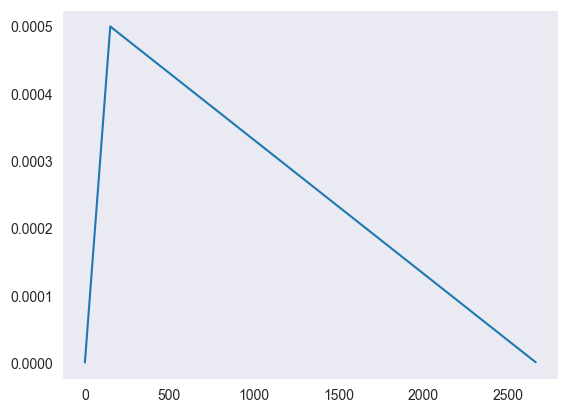

In [46]:
from matplotlib import pyplot as plt

steps = range(21340//8)
init_lr = 1e-6
peak_lr = 5e-4
final_lr = 1e-6
num_warmup_steps=150
num_training_steps=21340//8
lrs = []
for step in steps:
    if step <= num_warmup_steps:
        lr = init_lr + (peak_lr - init_lr) / num_warmup_steps * step
    else:
        lr =  peak_lr + (final_lr - peak_lr) / (num_training_steps - num_warmup_steps) * (step - num_warmup_steps)
    lrs.append(lr)
print(lrs[-1])
plt.plot(lrs)
plt.grid()
plt.show()

In [47]:
tests.test_scheduler(Scheduler, get_optimizer, model)

Correct.


In [48]:
scheduler = Scheduler(
    ###########################
    ### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
    ###########################
    optimizer,
    init_lr = 1e-6,
    peak_lr = 5e-4,
    final_lr = 1e-6,
    num_warmup_steps=150,
    num_training_steps=21340//8
)

От запуска обучения нас отделяет только создание `Trainer`. От объектов класса `Trainer` требуется, чтобы:
* логгировался лосс на каждом батче (`torch.utils.tensorboard.SummaryWriter`, `writer.add_scalar`)
* клипались и логгировались нормы градиентов при каждом шаге спуска (`torch.nn.utils.clip_grad_norm_` возвращает нормы градиентов)
* логгировались значения learning rate
* была поддержана аккумуляция градиентов, нужная для эмуляции больших батчей

При предобучении не нужно использовать какую-либо форму валидации, достаточно смотреть на батч лосс.

Предлагается также для ускорения обучения использовать mixed precision из библиотеки `apex`:
* перед обучением необходимо вызвать строчку вида `model, optimizer = amp.initialize(model, optimizer, opt_level='O1')`
* при обучении `.backward()` надо делать в контекстном менеджере:     
   `with amp.scale_loss(loss, optimizer) as scaled_loss: scaled_loss.backward()`
        
Что такое аккумуляция градиентов:
* При использовании Adam в видеопамяти необходимо хранить градиенты и квадраты частных производных
* При подсчете градиента по очередному батчу необязательно сразу делать шаг спуска, можно запомнить градиент, а затем посчитать градиент по другому батчу c теми же параметрами модели
* Теперь эти два градиента можно сложить и получить градиент, который был посчитан как будто по одному большому батчу (составленному из этих двух). Сэмулировали большой батч. В данном случае количество шагов аккумуляции равно двум.
* В данном случае количество шагов аккумуляции равно двум.

Зачем нужны большие батчи? Обучение быстрее, оценки градиента точнее, позволяет увеличивать learning rate. Например, при предобучении авторы RoBERTA значительно увеличили размер батча по сравнению с ванильным BERT и получили прирост к качеству решения целевых задач.

In [49]:
import os
import shutil
from collections import defaultdict

# from apex import amp

import torch
from torch.utils.tensorboard import SummaryWriter


class Trainer:

    def __init__(
            self, 
            model,
            optimizer, 
            scheduler,
            pad_token_id,
            device,
            num_accum_steps=1,
            logdir=None,
            max_grad_norm=None
    ):
        """
            model: объект класса BertModel
            optimizer: оптимизатор
            scheduler: расписание learning rate. Нужно вызывать scheduler.step() ПОСЛЕ optimizer.step()
            pad_token_id: индекс паддинга. Нужен для создания attention mask
            device: девайс (cpu или cuda), на котором надо производить вычисления
            num_accum_steps: количество шагов аккумуляции
            logdir: директория для записи логов
            max_grad_norm: максимум нормы градиентов, для клиппинга
        """
        ###########################
        ### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
        ###########################
        self._device = device
        # self._model, self._optimizer = amp.initialize(model.to(device), optimizer, opt_level='O1')
        self._model = model.to(device)
        self._optimizer = optimizer
        self._scheduler = scheduler
        self._pad_token_id = pad_token_id
        self._num_accum_steps = num_accum_steps
        self._max_grad_norm = max_grad_norm

        self._writer = SummaryWriter(logdir)
        self._n_epoch = 0

    def train(self, dataloader, n_epochs):
        for epoch in range(n_epochs):
            self._train_step(dataloader)
            self._n_epoch += 1

    def _train_step(self, dataloader):
        """
            dataloader: объект класса DataLoader для обучения
        """
        ###########################
        ### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
        ###########################
        batch_loss = .0
        for i, batch in tqdm.tqdm(enumerate(dataloader)):
            tokens, token_type_ids, labels, permuted = batch
            tokens = tokens.to(self._device)
            token_type_ids = token_type_ids.to(self._device)
            labels = labels.to(self._device)
            permuted = permuted.to(self._device).int()
            attention_mask = (tokens != self._pad_token_id).int()
            loss, _  = self._model(tokens, attention_mask, labels, permuted, token_type_ids=token_type_ids)
            # with amp.scale_loss(loss, optimizer) as scaled_loss:
            #     scaled_loss.backward()
            #     batch_loss += scaled_loss.item()
            loss.backward()
            batch_loss += loss.item()
            if i % self._num_accum_steps == 0:
                norm = torch.nn.utils.clip_grad_norm_(self._model.parameters(), max_norm=self._max_grad_norm)
                self._writer.add_scalar('loss', loss.item(), self._n_epoch + i)
                self._writer.add_scalar('norm', norm.item(), self._n_epoch + i)
                self._optimizer.step()
                self._optimizer.zero_grad()
                batch_loss = .0
                self._writer.add_scalar('lr', self._scheduler.get_last_lr()[-1], self._n_epoch + i)
                self._scheduler.step()

Обучите и сохраните предобученную модель с помощью `torch.save`. 

**Важно:** тензорборд логи успешного обучения необходимо сложить в архив и приложить вместе с решенным заданием.

Про гиперпараметры:
* `weight_decay` - $0.1, 0.01, 0.001$ и т.д.
* расписание lr - bert-mini не очень чувствителен к линейному вормапу, поэтому существенное влияние оказывают только пиковое и финальное значение lr. Пиковое значение стоит поискать где-то в масштабе 1e-3 - 1e-4, финальный lr можно сделать очень маленьким.
* конкретное значение для клиппинга нормы особо ни на что не влияет, как правило (и в оригинальной статье тоже) его всегда ставят единицой

In [50]:
assert torch.cuda.is_available()
device = torch.device('cuda')

trainer = Trainer(
    ###########################
    ### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
    ###########################
    model,
    optimizer,
    scheduler,
    tokenizer.pad_token_id,
    device,
    num_accum_steps=8,
    logdir='bert',
    max_grad_norm=1,
)
torch.cuda.empty_cache()

In [51]:
trainer.train(dl, n_epochs=1)
    
torch.save(
    model.state_dict(),
    'pretrained_weights.pt'
)

21339it [19:49, 17.95it/s]


После предобучения вам придется перезапустить ноутбук и снова перепрогнать блоки, нужные для дообучения. Использование apex'а ломает обучение других моделей (которые не передавались в `amp.initialize`) в одном запуске. Если не перезапустить, скор получится гораздо хуже.

In [514]:
%load_ext tensorboard
%tensorboard --logdir=BertMini

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Launching TensorBoard...

## Часть 4. Дообучение (5 баллов)

Самая сложная часть уже позади, осталось чуть-чуть :)

Так как для дообучения доступно гораздо меньше данных, оно занимает гораздо меньше времени.

In [52]:
train = data.loc[data['split'] == 'train'].reset_index(drop=True).copy()
val = data.loc[data['split'] == 'val'].reset_index(drop=True).copy()
test = data.loc[data['split'] == 'test'].reset_index(drop=True).copy()

Датасет для дообучения выглядит стандартно: нужно токенизировать и запомнить тексты и соответствующие им метки, и затем в методе `__getitem__` их выдавать:

In [53]:
class FinetuneDataset(Dataset):
    
    def __init__(
            self, 
            texts, 
            targets, 
            tokenizer,
            maxlen, 
            presort=False
    ):
        """
            texts: list of strings. Тексты чеков
            targets: list of ints. Категории товаров
            tokenizer: токенизатор
            maxlen: максимальная длина текста
            presort: отсортировать тексты по длине
        """
        ###########################
        ### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
        ###########################
        self._texts = [tokenizer(text) for text in tqdm.tqdm(texts)]
        self._targets = targets
        
        self._data = zip(self._texts, self._targets)
        if presort:
            self._data = sorted(self._data, key=lambda x: len(x[0]))
        self._data = list(self._data)
        self._maxlen = maxlen
                
    def __len__(self):
        return len(self._data)
    
    def __getitem__(self, idx):
        """
            returns: input_ids - индексы токенов токенизированного текста, target - категория
        """
        ###########################
        ### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
        ###########################
        input_ids, target = self._data[idx]
        input_ids = input_ids[:self._maxlen]
        return input_ids, target

Создайте датасеты для обучения и валидации:

In [54]:
train_ds = FinetuneDataset(
    train['text'].values, 
    train['label'].values, 
    maxlen=27,
    tokenizer=tokenizer
)
val_ds = FinetuneDataset(
    val['text'].values, 
    val['label'].values, 
    maxlen=27,
    tokenizer=tokenizer, 
    presort=True
)

100%|██████████| 4826/4826 [00:00<00:00, 13256.62it/s]


Коллатор для дообучения делает только паддинг и конвертацию таргетов в тензоры:

In [55]:
def collate_fn(batch, pad_idx):
    ###########################
    ### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
    ###########################
    max_len = max([len(input_ids) for input_ids, _ in batch])
    texts = []
    targets = []
    for text, target in batch:
        texts.append(torch.tensor(text + [pad_idx] * (max_len - len(text))))
        targets.append(target)
    return torch.stack(texts), torch.tensor(targets)
        

Создайте даталоадеры для обучения и валидации:

In [56]:
BATCH_SIZE = 32

dataloaders = {
    'train': DataLoader(
        train_ds,
        batch_size=BATCH_SIZE, 
        shuffle=True, 
        collate_fn=lambda batch: collate_fn(batch, tokenizer.pad_token_id)
    ),
    'eval': DataLoader(
        val_ds,
        batch_size=BATCH_SIZE, 
        shuffle=False, 
        collate_fn=lambda batch: collate_fn(batch, tokenizer.pad_token_id)
    )
}

В модели теперь отсутствует MLM голова, а вместо SOP задачи голова классификации решает задачу определения категорий товаров.

In [224]:
class BertFinetuneModel(nn.Module):

    def __init__(
            self, 
            hidden_size, 
            vocab_size, 
            max_seqlen,
            num_hidden_layers,
            intermediate_size,
            num_attention_heads,
            num_classes,
            act_func='relu',
            input_dropout_prob=0.,
            hidden_dropout_prob=0., 
            attention_probs_dropout_prob=0.,
            eps=1e-3
    ):
        super().__init__()
        self._backbone = Bert(
            vocab_size=vocab_size,
            max_seqlen=max_seqlen,
            hidden_size=hidden_size,
            num_hidden_layers=num_hidden_layers,
            intermediate_size=intermediate_size, 
            num_attention_heads=num_attention_heads, 
            input_dropout_prob=input_dropout_prob,
            dropout_prob=hidden_dropout_prob, 
            attention_probs_dropout_prob=attention_probs_dropout_prob,
            act_func=act_func,
            eps=eps
        )
        self._classifier_head = ClassifierHead(hidden_size, num_classes, hidden_dropout_prob)

    def forward(self, x, attention_mask):
        hidden_states = self._backbone(x, attention_mask)
        return self._classifier_head(hidden_states)

Используйте ту же архитектуру, которую вы выбрали при предобучении. Количество классов - 96:

In [236]:
model = BertFinetuneModel(
    ###########################
    ### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
    ###########################
    256,
    30000,
    29,
    4,
    4 * 256,
    256 // 64,
    96,
    hidden_dropout_prob=0.05,
    input_dropout_prob=0.05,
    attention_probs_dropout_prob=0.05
)

Подгрузить предобученные веса можно с помощью следующей функции:

In [237]:
def load_weights(self, path):
    found = []
    with open(path, 'rb') as f:
        weights = torch.load(f)
    for name, param in weights.items():
        if name in self.state_dict():
            if param.shape == self.state_dict()[name].shape:
                self.state_dict()[name].copy_(param)
                found.append(name)

    return found

found = load_weights(model, 'pretrained_weights.pt')

print('Amount of found weights: {}'.format(len(found)))

Amount of found weights: 55


Создайте оптимизатор и расписание лр. Про гиперпараметры:
* при дообучении используют маленький batch_size $\in \{32, 64\}$
* маленький learning rate:  $\{1e-5, 2e-5, 4e-5\}$ для больших моделей, для моделей вида bert-mini можно использовать и побольше: $\{1e-4, 2e-4, 4e-4\}$ 
* финальное значение все также маленькое
* вормап можно делать где-то 0.06 от всех шагов обучения
* количество эпох для дообучения - больше шести здесь не нужно
* weight decay здесь потенциально можно использовать побольше, чем при предобучении

In [238]:
optimizer = get_optimizer(model, weight_decay=0.01)
scheduler = Scheduler(
    ###########################
    ### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
    ###########################
    optimizer,
    init_lr=1e-5,
    peak_lr=4e-4,
    final_lr=1e-6,
    num_warmup_steps=int(0.1 * 1207 * 100),
    num_training_steps=1207 * 100
)

Осталось создать пайплайн обучения:
* apex использовать не нужно, дообучение быстрое и не требует больших батчей
* аккумуляция градиентов не нужна т.к. батчи  маленькие
* лосс теперь считается вне модели, в Trainer нужно использовать torch.nn.CrossEntropyLoss

In [239]:
class FinetuneTrainer:

    def __init__(
            self, 
            model, 
            optimizer, 
            scheduler,
            pad_token_id,
            device,
            logdir=None,
            max_grad_norm=None
    ):
        """
            model: объект класса BertModel
            optimizer: оптимизатор
            scheduler: расписание learning rate. Нужно вызывать scheduler.step() ПОСЛЕ optimizer.step()
            pad_token_id: индекс паддинга. Нужен для создания attention mask
            device: девайс (cpu или cuda), на котором надо производить вычисления
            num_accum_steps: количество шагов аккумуляции
            logdir: директория для записи логов
            max_grad_norm: максимум нормы градиентов, для клиппинга
        """
        ###########################
        ### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
        ###########################
        self._device = device
        self._model = model.to(self._device)
        self._optimizer = optimizer
        self._scheduler = scheduler
        self._pad_token_id = pad_token_id
        self._writer = SummaryWriter(logdir)
        self._max_grad_norm = max_grad_norm if max_grad_norm is not None else 1.
        self._criterion = nn.CrossEntropyLoss()
        
        
        
    def train(self, dataloaders, n_epochs, scorer=None):
        """
            dataloaders: dict of dataloaders, keys 'train', 'eval' should be present.
            n_epochs: int. Num epochs to train for.
            scorer: takes trainer, outputs metric name and value as a tuple.
        """
        for i, epoch in enumerate(tqdm.tqdm(range(n_epochs))):
            train_loss = self._train_step(dataloaders['train'])
            print(f'train_loss: {train_loss}')
            val_loss = self._eval_step(dataloaders['eval'])
            print(f'val_loss: {val_loss}')
            if self._writer is not None:
                self._writer.add_scalar('eval', val_loss, global_step=i)

                if scorer is not None:
                    name, value = scorer(self)
                    self._writer.add_scalar(name, value, global_step=i)
                    
    def _train_step(self, dataloader):
        """
            dataloader: training dataloader.
            
            returns: train_loss
        """
        ###########################
        ### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
        ###########################
        self._model.train()
        total_loss = 0.0
        for batch in dataloader:
            input_ids, targets = batch
            input_ids = input_ids.to(self._device)
            targets = targets.to(self._device)
            attention_mask = (input_ids != self._pad_token_id).int()
            out = self._model(input_ids, attention_mask)
            loss = self._criterion(out, targets)
            self._optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(self._model.parameters(), self._max_grad_norm)
            self._optimizer.step()
            self._scheduler.step()
            total_loss += loss.item()
        return total_loss / len(dataloader)

    def _eval_step(self, dataloader):
        """
            dataloader: evaluation dataloader.
            
            returns: eval loss
        """
        ###########################
        ### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
        ###########################
        self._model.eval()
        total_loss = 0.0
        with torch.no_grad():
            for batch in dataloader:
                input_ids, targets = batch
                input_ids = input_ids.to(self._device)
                targets = targets.to(self._device)
                attention_mask = (input_ids != self._pad_token_id).int()
                out = self._model(input_ids, attention_mask)
                loss = self._criterion(out, targets)
                total_loss += loss.item()
        return total_loss / len(dataloader)
    
    def predict(self, dataloader):
        """
            dataloader: inference dataloader. Should not have targets.
            
            returns: np.array c предсказанными категориями
        """
        ###########################
        ### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
        ###########################
        self._model.eval()
        with torch.no_grad():
            preds = []
            for input_ids in dataloader:
                input_ids = input_ids.to(self._device)
                attention_mask = (input_ids != self._pad_token_id).int()
                out = self._model(input_ids, attention_mask)
                preds.append(torch.argmax(out, dim=-1))
            return torch.cat(preds).cpu().numpy()

In [240]:
device = torch.device('cuda')

trainer = FinetuneTrainer(
    ###########################
    ### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
    ###########################
    model,
    optimizer,
    scheduler,
    tokenizer.pad_token_id,
    device,
    logdir='bert_finetuned',
)

Для мониторинга целевой метрики используйте предоставленный scorer:

In [241]:
from sklearn.metrics import f1_score


class InferenceDataset(Dataset):
    
    def __init__(self, texts, maxlen, tokenizer):
        """
            texts: list of str. Сырые тексты чеков
            maxlen: максимальная длина текста
            tokenizer: токенизатор
        """
        self._texts = [tokenizer(text) if tokenizer is not None else text for text in texts]
        self._maxlen = maxlen
        
    def __len__(self):
        return len(self._texts)
    
    def __getitem__(self, idx):
        """
            returns: тензор из индексов токенов токенизированного текста
        """
        text = self._texts[idx]
        if self._maxlen is not None:
            text = text[:self._maxlen]
        return torch.tensor(text, dtype=torch.long)
    
def make_scorer(texts, targets, tokenizer, maxlen):
    inference_ds = InferenceDataset(texts, maxlen=maxlen, tokenizer=tokenizer)
    inference_dl = DataLoader(inference_ds, batch_size=32, shuffle=False, collate_fn=inference_collate_fn)
    def get_score(trainer):
        preds = trainer.predict(inference_dl)
        return 'f1', f1_score(targets, preds, average='weighted')
    return get_score


inference_collate_fn = lambda x: pad_sequence(x, batch_first=True, padding_value=tokenizer.pad_token_id)

val_scorer = make_scorer(val['text'].values, val['label'].values, tokenizer, maxlen=27)

Скор на валидационной выборке до обучения:

In [242]:
val_scorer(trainer)

('f1', 0.005064325955089505)

In [243]:
trainer.train(dataloaders, n_epochs=100, scorer=val_scorer)

  0%|          | 0/100 [00:00<?, ?it/s]

train_loss: 3.701567878975983
val_loss: 3.4699790746170955


  1%|          | 1/100 [00:26<44:32, 26.99s/it]

train_loss: 3.3183523318741868
val_loss: 3.342325235834185


  2%|▏         | 2/100 [00:52<42:30, 26.02s/it]

train_loss: 3.1397225511103697
val_loss: 3.2064189374052137


  3%|▎         | 3/100 [01:17<41:40, 25.78s/it]

train_loss: 2.9157377838989675
val_loss: 2.9527121679672343


  4%|▍         | 4/100 [01:43<40:52, 25.54s/it]

train_loss: 2.65078433940701
val_loss: 2.8168034158795083


  5%|▌         | 5/100 [02:08<40:14, 25.41s/it]

train_loss: 2.4329479663156732
val_loss: 2.852984016304774


  6%|▌         | 6/100 [02:33<39:41, 25.34s/it]

train_loss: 2.302820519464709
val_loss: 2.756617183716881


  7%|▋         | 7/100 [02:58<39:11, 25.29s/it]

train_loss: 2.18346105188798
val_loss: 2.6244171210472156


  8%|▊         | 8/100 [03:23<38:41, 25.24s/it]

train_loss: 2.0668441733745078
val_loss: 2.5274580946031784


  9%|▉         | 9/100 [03:49<38:20, 25.28s/it]

train_loss: 1.9594098192754617
val_loss: 2.4997801488598452


 10%|█         | 10/100 [04:14<37:57, 25.31s/it]

train_loss: 1.858002822806051
val_loss: 2.418680892874863


 11%|█         | 11/100 [04:39<37:30, 25.29s/it]

train_loss: 1.7522001267467142
val_loss: 2.279445444511262


 12%|█▏        | 12/100 [05:05<37:06, 25.30s/it]

train_loss: 1.6656028454523
val_loss: 2.248948870905188


 13%|█▎        | 13/100 [05:30<36:39, 25.29s/it]

train_loss: 1.5831022288252128
val_loss: 2.3530190492307903


 14%|█▍        | 14/100 [05:55<36:12, 25.27s/it]

train_loss: 1.5218858881340407
val_loss: 2.2588472871590923


 15%|█▌        | 15/100 [06:20<35:45, 25.24s/it]

train_loss: 1.458094800071669
val_loss: 2.2464090029135444


 16%|█▌        | 16/100 [06:45<35:19, 25.24s/it]

train_loss: 1.4044793799778796
val_loss: 2.189898411169747


 17%|█▋        | 17/100 [07:11<34:56, 25.26s/it]

train_loss: 1.3547957579558214
val_loss: 2.160193075012687


 18%|█▊        | 18/100 [07:36<34:30, 25.25s/it]

train_loss: 1.2979171009921
val_loss: 2.109457628616434


 19%|█▉        | 19/100 [08:01<34:08, 25.29s/it]

train_loss: 1.2585052197741988
val_loss: 2.1032797634996325


 20%|██        | 20/100 [08:27<33:44, 25.30s/it]

train_loss: 1.2202715482115252
val_loss: 2.0944920782221863


 21%|██        | 21/100 [08:52<33:15, 25.27s/it]

train_loss: 1.1858783942564717
val_loss: 2.131435980859971


 22%|██▏       | 22/100 [09:17<32:48, 25.23s/it]

train_loss: 1.1520092683877448
val_loss: 2.1243639173886635


 23%|██▎       | 23/100 [09:42<32:25, 25.26s/it]

train_loss: 1.118719314037519
val_loss: 2.191020408213533


 24%|██▍       | 24/100 [10:07<31:58, 25.24s/it]

train_loss: 1.0839915085698122
val_loss: 2.1645413499004795


 25%|██▌       | 25/100 [10:33<31:31, 25.22s/it]

train_loss: 1.0505423235715472
val_loss: 2.072399828607673


 26%|██▌       | 26/100 [10:58<31:13, 25.32s/it]

train_loss: 1.0223826658360309
val_loss: 2.058548225472305


 27%|██▋       | 27/100 [11:23<30:44, 25.27s/it]

train_loss: 0.9974332255771956
val_loss: 2.0695214421543855


 28%|██▊       | 28/100 [11:49<30:17, 25.24s/it]

train_loss: 0.9689594339810824
val_loss: 2.0459028324544035


 29%|██▉       | 29/100 [12:14<29:52, 25.25s/it]

train_loss: 0.9465810973089197
val_loss: 1.9861858266078873


 30%|███       | 30/100 [12:39<29:26, 25.23s/it]

train_loss: 0.9229069321162462
val_loss: 2.0678162523452808


 31%|███       | 31/100 [13:04<29:00, 25.22s/it]

train_loss: 0.8953190066766028
val_loss: 2.0786587722254115


 32%|███▏      | 32/100 [13:29<28:35, 25.22s/it]

train_loss: 0.879315367528695
val_loss: 2.0663908597649328


 33%|███▎      | 33/100 [13:55<28:09, 25.22s/it]

train_loss: 0.8580991987327258
val_loss: 2.111091339825005


 34%|███▍      | 34/100 [14:20<27:44, 25.22s/it]

train_loss: 0.8399432129608567
val_loss: 2.094275910728025


 35%|███▌      | 35/100 [14:45<27:22, 25.27s/it]

train_loss: 0.8140995023708849
val_loss: 2.093861504501065


 36%|███▌      | 36/100 [15:11<27:00, 25.33s/it]

train_loss: 0.7946120020690395
val_loss: 2.037354872716184


 37%|███▋      | 37/100 [15:36<26:35, 25.32s/it]

train_loss: 0.7831033977379755
val_loss: 2.0688880713570197


 38%|███▊      | 38/100 [16:01<26:07, 25.29s/it]

train_loss: 0.7645485026031955
val_loss: 2.074088279379914


 39%|███▉      | 39/100 [16:26<25:41, 25.27s/it]

train_loss: 0.7463132624870109
val_loss: 2.1160045633252884


 40%|████      | 40/100 [16:52<25:17, 25.30s/it]

train_loss: 0.7330212252092638
val_loss: 2.147448551970602


 41%|████      | 41/100 [17:17<24:50, 25.26s/it]

train_loss: 0.7195227030902336
val_loss: 2.105921949377123


 42%|████▏     | 42/100 [17:42<24:25, 25.26s/it]

train_loss: 0.7007374022134395
val_loss: 2.0784545892121775


 43%|████▎     | 43/100 [18:08<24:00, 25.28s/it]

train_loss: 0.6963081442578923
val_loss: 2.0426318270481185


 44%|████▍     | 44/100 [18:33<23:35, 25.27s/it]

train_loss: 0.6713333015685844
val_loss: 2.0620784897677944


 45%|████▌     | 45/100 [18:58<23:12, 25.32s/it]

train_loss: 0.6575763186543266
val_loss: 2.0814932999231957


 46%|████▌     | 46/100 [19:24<22:46, 25.31s/it]

train_loss: 0.643624632383983
val_loss: 2.0739973140078662


 47%|████▋     | 47/100 [19:49<22:21, 25.31s/it]

train_loss: 0.6401295963745771
val_loss: 2.091303401040715


 48%|████▊     | 48/100 [20:14<21:54, 25.28s/it]

train_loss: 0.6260861693738706
val_loss: 2.0981610847624723


 49%|████▉     | 49/100 [20:39<21:30, 25.30s/it]

train_loss: 0.6147929371366248
val_loss: 2.0785923888351743


 50%|█████     | 50/100 [21:05<21:04, 25.29s/it]

train_loss: 0.5983976160840447
val_loss: 2.1430232023561238


 51%|█████     | 51/100 [21:30<20:38, 25.28s/it]

train_loss: 0.5879585375390521
val_loss: 2.0895942058784285


 52%|█████▏    | 52/100 [21:55<20:13, 25.27s/it]

train_loss: 0.5756287499459796
val_loss: 2.1019452731340924


 53%|█████▎    | 53/100 [22:21<19:49, 25.31s/it]

train_loss: 0.5578101248339177
val_loss: 2.1257337260719957


 54%|█████▍    | 54/100 [22:46<19:26, 25.37s/it]

train_loss: 0.5593490868794493
val_loss: 2.09834040908624


 55%|█████▌    | 55/100 [23:11<19:00, 25.34s/it]

train_loss: 0.5560713710005657
val_loss: 2.086319751297401


 56%|█████▌    | 56/100 [23:37<18:33, 25.32s/it]

train_loss: 0.5369059376298221
val_loss: 2.091339009881809


 57%|█████▋    | 57/100 [24:02<18:09, 25.33s/it]

train_loss: 0.5321218090250706
val_loss: 2.1341952926275747


 58%|█████▊    | 58/100 [24:27<17:46, 25.39s/it]

train_loss: 0.5162851644607374
val_loss: 2.216176569856555


 59%|█████▉    | 59/100 [24:53<17:19, 25.35s/it]

train_loss: 0.5069251531440311
val_loss: 2.1362349039671438


 60%|██████    | 60/100 [25:18<16:54, 25.36s/it]

train_loss: 0.4982077854175457
val_loss: 2.1093343073958595


 61%|██████    | 61/100 [25:44<16:29, 25.38s/it]

train_loss: 0.48963545841823064
val_loss: 2.1007582111074434


 62%|██████▏   | 62/100 [26:09<16:02, 25.33s/it]

train_loss: 0.48396502012987225
val_loss: 2.1283857861891486


 63%|██████▎   | 63/100 [26:34<15:36, 25.30s/it]

train_loss: 0.47798727846425876
val_loss: 2.127094113866225


 64%|██████▍   | 64/100 [26:59<15:09, 25.27s/it]

train_loss: 0.46976682963659916
val_loss: 2.179541880721288


 65%|██████▌   | 65/100 [27:25<14:46, 25.32s/it]

train_loss: 0.46249215365190743
val_loss: 2.1129422578590593


 66%|██████▌   | 66/100 [27:50<14:20, 25.30s/it]

train_loss: 0.4514280910223303
val_loss: 2.167238297446674


 67%|██████▋   | 67/100 [28:15<13:54, 25.28s/it]

train_loss: 0.44029858066718147
val_loss: 2.1691647183816163


 68%|██████▊   | 68/100 [28:40<13:29, 25.28s/it]

train_loss: 0.44095327693339387
val_loss: 2.224416997653759


 69%|██████▉   | 69/100 [29:06<13:04, 25.30s/it]

train_loss: 0.43360503134414147
val_loss: 2.194152467298192


 70%|███████   | 70/100 [29:31<12:38, 25.29s/it]

train_loss: 0.42613029513004996
val_loss: 2.1600979834992367


 71%|███████   | 71/100 [29:56<12:12, 25.27s/it]

train_loss: 0.41942269514780106
val_loss: 2.2091176963799835


 72%|███████▏  | 72/100 [30:22<11:48, 25.32s/it]

train_loss: 0.41668044162764467
val_loss: 2.1959814674017446


 73%|███████▎  | 73/100 [30:47<11:23, 25.33s/it]

train_loss: 0.4043864593412897
val_loss: 2.204658996979922


 74%|███████▍  | 74/100 [31:12<10:58, 25.32s/it]

train_loss: 0.4004086631071671
val_loss: 2.178980072207798


 75%|███████▌  | 75/100 [31:38<10:33, 25.33s/it]

train_loss: 0.39359052636982395
val_loss: 2.2316068410873413


 76%|███████▌  | 76/100 [32:03<10:07, 25.31s/it]

train_loss: 0.389221475796825
val_loss: 2.247095055927504


 77%|███████▋  | 77/100 [32:28<09:41, 25.29s/it]

train_loss: 0.379601682783988
val_loss: 2.1973641483199517


 78%|███████▊  | 78/100 [32:53<09:15, 25.27s/it]

train_loss: 0.38258113793399134
val_loss: 2.267360702255704


 79%|███████▉  | 79/100 [33:19<08:50, 25.27s/it]

train_loss: 0.3721067437094998
val_loss: 2.21912224363807


 80%|████████  | 80/100 [33:44<08:25, 25.27s/it]

train_loss: 0.3689488232237624
val_loss: 2.225525698124968


 81%|████████  | 81/100 [34:09<07:59, 25.26s/it]

train_loss: 0.36037271116901104
val_loss: 2.254538140549565


 82%|████████▏ | 82/100 [34:35<07:35, 25.29s/it]

train_loss: 0.3584844986379591
val_loss: 2.234530273257502


 83%|████████▎ | 83/100 [35:00<07:09, 25.28s/it]

train_loss: 0.3462316551798987
val_loss: 2.2289377214103343


 84%|████████▍ | 84/100 [35:25<06:44, 25.28s/it]

train_loss: 0.3470008420590512
val_loss: 2.22824357716453


 85%|████████▌ | 85/100 [35:51<06:19, 25.32s/it]

train_loss: 0.3406454625639018
val_loss: 2.2558662741389495


 86%|████████▌ | 86/100 [36:16<05:53, 25.28s/it]

train_loss: 0.33597840221449055
val_loss: 2.2342668530956797


 87%|████████▋ | 87/100 [36:41<05:28, 25.26s/it]

train_loss: 0.33345464427894494
val_loss: 2.2108400819317393


 88%|████████▊ | 88/100 [37:06<05:03, 25.25s/it]

train_loss: 0.33290078106715154
val_loss: 2.2034390912150705


 89%|████████▉ | 89/100 [37:32<04:38, 25.31s/it]

train_loss: 0.32591575473568585
val_loss: 2.2203042171648795


 90%|█████████ | 90/100 [37:57<04:12, 25.29s/it]

train_loss: 0.3265134000575113
val_loss: 2.2165474654822948


 91%|█████████ | 91/100 [38:22<03:47, 25.26s/it]

train_loss: 0.3222787001516667
val_loss: 2.21562208797758


 92%|█████████▏| 92/100 [38:47<03:21, 25.25s/it]

train_loss: 0.31689545921302326
val_loss: 2.2231088142521336


 93%|█████████▎| 93/100 [39:12<02:56, 25.24s/it]

train_loss: 0.310742840260366
val_loss: 2.209496577449192


 94%|█████████▍| 94/100 [39:38<02:31, 25.27s/it]

train_loss: 0.3102686176633627
val_loss: 2.2271024616348822


 95%|█████████▌| 95/100 [40:03<02:06, 25.28s/it]

train_loss: 0.3043491991688964
val_loss: 2.2166937467278234


 96%|█████████▌| 96/100 [40:28<01:41, 25.27s/it]

train_loss: 0.30387753738953044
val_loss: 2.2194195318695726


 97%|█████████▋| 97/100 [40:54<01:15, 25.30s/it]

train_loss: 0.30706933563283484
val_loss: 2.2205921170727305


 98%|█████████▊| 98/100 [41:19<00:50, 25.29s/it]

train_loss: 0.29556435431479516
val_loss: 2.219277879260234


 99%|█████████▉| 99/100 [41:44<00:25, 25.33s/it]

train_loss: 0.2953563026710419
val_loss: 2.219425688516225


100%|██████████| 100/100 [42:10<00:00, 25.30s/it]


Одним из критериев получения полного балла за задание является получение на тесте значения метрики $\geqslant 0.7$. Скор на тестовой выборке:

In [244]:
test_scorer = make_scorer(test['text'].values, test['label'].values, tokenizer, maxlen=27)

test_scorer(trainer)

('f1', 0.7128774626120189)

Не забудьте также приложить вместе со сделанным заданием тензорборд дообучения.

**Вопросы:**
1. Попробуйте также обучить модель без предобученных весов (просто закомментировав загрузку весов). Насколько сильно просело качество?
2. Влияет ли длительность предобучения (количество эпох) как-то существенно на дообучение, или достаточно одной эпохи?

**Ваши ответы напишите здесь:**
1. Качество стало плохим, почти нулевым.
2. Влияет. Нужно провести где-то 6 эпох для получения приемлемого качества. Возможно, грамотная настройка темпа обучения позволит проводить всего одну эпоху дообучения.

## Бонусная часть. Большие модели (максимум 3 балла)

Предлагается обучить модель побольше:
* `hidden_size` $\in \{512, 768, 1024\}$
* `num_hidden_layers` $\in \{8, 12, 24\}$

Например, BERT-base архитектура выглядит как `hidden_size=768, num_hidden_layers=12`.

Для большой модели придется также использовать другие гиперпараметры - нужен learning rate поменьше, weight decay побольше, дропаут больше. Возможно потребуется больше эпох предобучения.

За выполнение этой части можно получить **до пяти бонусных баллов**, бонус зависит от полученных на тесте значений метрики (должно быть видно существенное улучшение).